## Training on MNIST Dataset with Contrastive Pairs Loss
-------------------------

In [4]:
import os
import torch
import torchvision
#import torchsummary
import matplotlib.pyplot as plt
import torch
import numpy as np
import cv2
from torch import nn
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchvision import transforms, models

os.chdir('..'); 
# print(os.getcwd())
from qssl.training.trainers import Trainer
from qssl.loss.losses import ContrastiveLoss
from qssl.data.data_loader import LabeledContrastiveDatasetQG
from qssl.utils.utils import extract_embeddings, plot_embeddings


In [2]:
# Hyperparameters
N = 3000
EMB_SIZE = 32
DEVICE = 'cuda'
LR = 0.0005
EPOCHS = 10
MARGIN = 1.0
NAME = 'QG_PAIR_LOSS_' + '_'.join([str(N), str(EMB_SIZE), str(LR), str(EPOCHS), str(MARGIN)])

# Reproduciblity
SEED = 911
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)

## Create Dataloader and Inspect Data
---------------------

In [3]:
root = r'data/qg_10_pairs_compressed.npz'
lcd = LabeledContrastiveDatasetQG(root)

In [4]:
datadict = lcd.__getitem__(4)
print(datadict["x1"].shape); print(datadict["x2"].shape)

torch.Size([10, 1, 40, 40])
torch.Size([10, 1, 40, 40])


In [5]:
from torchvision import transforms


train_sampler = SubsetRandomSampler(range(int(N*0.9)))
test_sampler = SubsetRandomSampler(range(int(N*0.9), N))

siamese_train_loader = torch.utils.data.DataLoader(lcd, batch_size=None, sampler=train_sampler)
siamese_test_loader = torch.utils.data.DataLoader(lcd, batch_size=None, shuffle=test_sampler)


## Model
------------

In [6]:
embedding_net = models.resnet18()
embedding_net.conv1 = nn.Conv2d(1, 64, (40,40), (4,4), (3,3))
embedding_net.fc = nn.Linear(512, EMB_SIZE)
model = embedding_net
model.train(); print() ; #torchsummary.summary(model, input_size = [(1,28,28),(1, 28, 28)], device=DEVICE)

## Training
-------------------------

In [7]:
import wandb
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\satvi\.netrc


True

In [8]:

run = wandb.init(
    project = "ML4Sci-QuantumContrastiveLearning",
    config = {
        "dataset":"QG-10",
        "model":"Classical Resnet",
        "loss":"contrastive pair loss"
    }
)

wandb: Currently logged in as: sanya (team-sanya). Use `wandb login --relogin` to force relogin


In [9]:
TL = ContrastiveLoss(margin=1.0, mode='pairs')

t = Trainer(model = model, 
            dataloader = siamese_train_loader,
            lr=LR,
            loss_function= TL)

In [10]:
losses, accuracy = t.train(EPOCHS, print_every=1)#, writer = writer)

----- Epoch: 0 -----


100%|██████████| 2700/2700 [11:09<00:00,  4.03it/s]


Avg train loss: 0.0052619419823510824
Avg train accuracy: 0.6
----- Epoch: 1 -----


100%|██████████| 2700/2700 [11:23<00:00,  3.95it/s]


Avg train loss: 0.0027228489878964074
Avg train accuracy: 0.6
----- Epoch: 2 -----


100%|██████████| 2700/2700 [10:30<00:00,  4.28it/s]


Avg train loss: 0.0018266237354395848
Avg train accuracy: 0.6
----- Epoch: 3 -----


100%|██████████| 2700/2700 [10:43<00:00,  4.20it/s]


Avg train loss: 0.0014285474813563728
Avg train accuracy: 0.6
----- Epoch: 4 -----


100%|██████████| 2700/2700 [11:22<00:00,  3.96it/s]


Avg train loss: 0.0011429273812649096
Avg train accuracy: 0.6
----- Epoch: 5 -----


100%|██████████| 2700/2700 [10:29<00:00,  4.29it/s]


Avg train loss: 0.0009590961810585621
Avg train accuracy: 0.6
----- Epoch: 6 -----


100%|██████████| 2700/2700 [11:15<00:00,  4.00it/s]


Avg train loss: 0.0008221121239085872
Avg train accuracy: 0.6
----- Epoch: 7 -----


100%|██████████| 2700/2700 [11:23<00:00,  3.95it/s]


Avg train loss: 0.0007193692084743175
Avg train accuracy: 0.6
----- Epoch: 8 -----


100%|██████████| 2700/2700 [11:14<00:00,  4.01it/s]


Avg train loss: 0.0006394467423818013
Avg train accuracy: 0.6
----- Epoch: 9 -----


100%|██████████| 2700/2700 [11:10<00:00,  4.03it/s]


Avg train loss: 0.0005770360700742733
Avg train accuracy: 0.5999999999999999


Text(0.5, 0, 'Epochs')

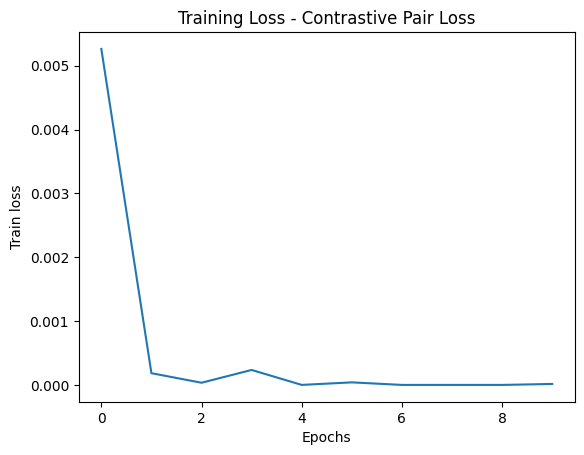

In [11]:
plt.plot(losses)
plt.title("Training Loss - Contrastive Pair Loss")
plt.ylabel("Train loss"); plt.xlabel("Epochs")

In [12]:
wandb.log({"losses":losses, "accuracy":accuracy})

## Inspecting Embeddings
-------------------

In [13]:
EMBS_TO_VISUALIZE = N - int(N*0.9)

In [14]:
test_embs = extract_embeddings(siamese_test_loader, model, EMBS_TO_VISUALIZE, reduce_to_dimension=2)

performing PCA to reduce embeddings to 2 dimensions
0.86266994 % variance explained using PCA


In [15]:
test_embs.head()

,Emb,Label
0,"[-2.3607876, -0.30890572]",0
1,"[0.0070080627, 0.1852568]",0
2,"[-1.3795422, -0.8592131]",1
3,"[1.8944055, 3.7478456]",0
4,"[-1.9717064, -0.28366607]",1


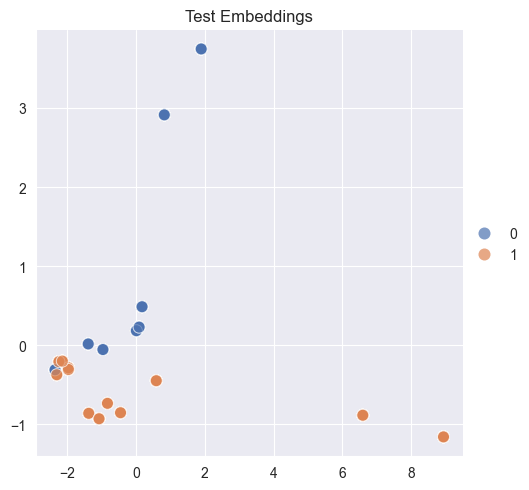

In [16]:
# wandb inside function
plot_embeddings(test_embs)

In [18]:
from Code.training.trainers import Tester

In [19]:
tester = Tester(
    model = model, 
    dataloader = siamese_test_loader,
    classes = ["Quark", "Gluon"]
)

In [20]:
tester.test()

Test accuracy:  60.00000000000001


(0.6000000000000001,
 tensor([0., 0., 1., 0., 1., 0., 1., 1., 1., 1.]),
 tensor([0, 1, 1, 1, 1, 1, 1, 1, 0, 1]))

Test accuracy:  60.00000000000001


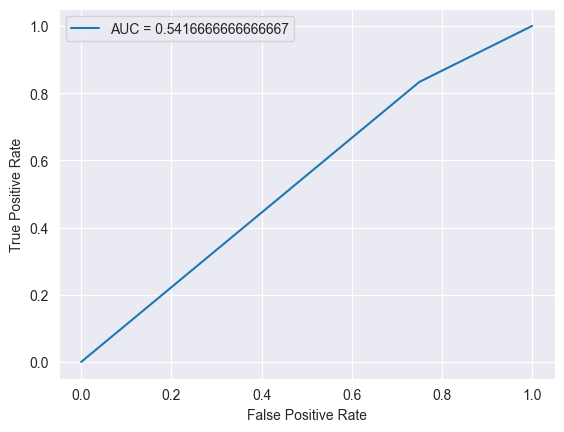

In [21]:
# wandb inside function
tester.auc()

Test accuracy:  60.00000000000001


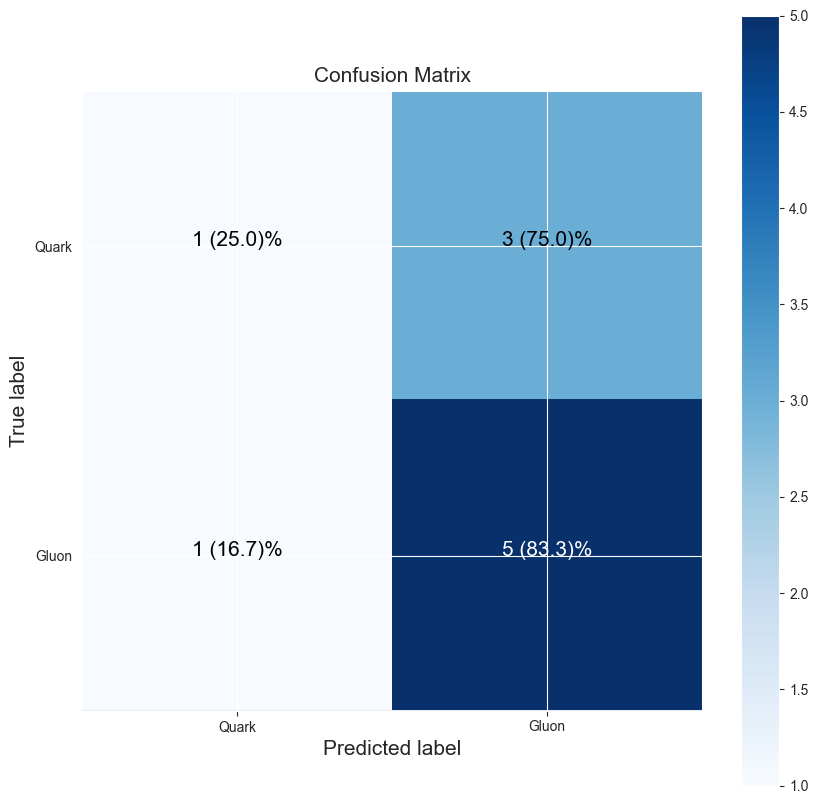

In [22]:
# wandb inside function
tester.confusion_matrix()

In [23]:
wandb.finish()